# CaffeNet for PADs
CaffeNet for PADs implemented in Tensorflow.

In [55]:
# We use the following line to allow us to embed plots in Jupyter notebooks
%matplotlib notebook

# Load libraries. We need tensorflow and numpy for training the CNN,
# matplotlib for plotting, os.path and PIL for loading images,
# and random to partition the data into test and training sets
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math
from os.path import dirname, abspath
from os.path import join
import os.path
import PIL
import random
import urllib.request
from PIL import Image, ImageEnhance, ImageStat

#seed random for putting images into training and test arrays
random.seed(1234)

In [3]:
#variables
classes = 9 #Amoxicillin rerun,Acetaminophen,Ciprofloxacin,Ceftriaxone,Metformin,Ampicillin,Azithromycin,Cefuroxime Axetil,Levofloxacin

#Flags to create train and test variables first time through
firstTrain = True
firstTest = True

#load training images
with open('images/train/label.txt') as f:
    #get lines
    train_labels = f.readlines()
    
    #loop over label lines
    for labels in train_labels:
        #get filename/label
        file, label = labels.split(' ')
        
        #Load png file using the PIL library
        im = PIL.Image.open(join('images', file))

        #add flattened image to train
        if firstTrain:
            #first time just set the train array to equal the first image
            #also reset the flag to false
            firstTrain = False

            #save the image as a (1, 154587) vector. Images are 224x224 pixels
            train = np.mat(np.asarray(im).flatten())
            #add a "1 hot" vector to the label array
            trainLabel = np.mat(np.eye(classes)[int(label)])
        else:
            #append once we have saved the first image               
            train = np.append(train, np.mat(np.asarray(im).flatten()), axis=0)
            #add a "1 hot" vector to the label array
            trainLabel = np.append(trainLabel, np.mat(np.eye(classes)[int(label)]), axis=0)

#load testing images
with open('images/test/label.txt') as f:
    #get lines
    test_labels = f.readlines()
    
    #loop over label lines
    for labels in test_labels:
        #get filename/label
        file, label = labels.split(' ')
        
        #Load png file using the PIL library
        im = PIL.Image.open(join('images', file))

        #add flattened image to train
        if firstTest:
            #first time just set the test array to equal the first image
            #also reset the flag to false
            firstTest = False

            #save the image as a (1, 154587) vector. Images are 224x224 pixels
            test = np.mat(np.asarray(im).flatten())
            #add a "1 hot" vector to the label array
            testLabel = np.mat(np.eye(classes)[int(label)])
        else:
            #append once we have saved the first image               
            test = np.append(test, np.mat(np.asarray(im).flatten()), axis=0)
            #add a "1 hot" vector to the label array
            testLabel = np.append(testLabel, np.mat(np.eye(classes)[int(label)]), axis=0)

print("Train size",train.shape, trainLabel.shape)
print("Test size",test.shape, testLabel.shape)

Train size (640, 154587) (640, 9)
Test size (260, 154587) (260, 9)


In [7]:
# Parameters for training
#learning rate is the step size that we move in the opposite direction of the gradient for each weight/bias
learning_rate = 1e-4 
#an epoch represents having trained with a number of images equal to the training test size
max_epochs = 100
display_step_size = 10 # Number of iterations before checking on the performance of network (validation)
#the prob_keep parameter represents the dropout, probability to keep units. This makes the network more robust
prob_keep = 0.5

#max pooling values
mx_pooling_size = 2        #max pooling size 2 *2
mx_pooling_window = 3      #max pooling window 3 *3

# Convolutional Layer 1.
filter_size1 = 11          # Convolution filters are 11 x 11 pixels.
num_filters1 = 96
filter_stride1 = 4

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 256

# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 384

# Convolutional Layer 4.
filter_size4 = 3          # Convolution filters are 3 x 3 pixels.
num_filters4 = 384

# Convolutional Layer 5.
filter_size5 = 3          # Convolution filters are 3 x 3 pixels.
num_filters5 = 256

# Fully-connected layers.
fc_neurons1 = 4096         # Number of neurons in fully-connected layer.
fc_neurons2 = 4096         # Number of neurons in second fully-connected layer.


#Image properties
img_shape = (227, 227)

#the images are color so 3 channels
channels = 3

#location of the weights/biases and architecture for the CNN checkpoint
model_checkpoint = "tmp/caffenet_pad_1.ckpt"

#image batch size
image_batch_size = 128

In [28]:
# Define CNN
#create place holders, these will be loaded with data as we train
X = tf.placeholder(tf.float32, shape=[None, img_shape[0]*img_shape[1]*channels], name='X') #the set of input images
X_image = tf.reshape(X, [-1, img_shape[0], img_shape[1], channels]) #a single image
Y = tf.placeholder(tf.float32, shape=[None, classes], name='Y')     #the label set
Y_classes = tf.argmax(Y, axis=1)                               #the classes(subjects)

#dropout (keep probability)
keep_prob = tf.placeholder(tf.float32)

#initial weight values
def generate_weights(shape, name):
    # Create new matrix
    return tf.Variable(tf.truncated_normal(shape, stddev=5e-2), name=name)

#initial bias values
def generate_biases(size, name):
    #create biases
    return tf.Variable(tf.constant(0.0, shape=[size]), name=name)

# compute convolutions with relu output
def convolution(input_data,num_channels, filter_size, num_filters, stride, name_w, name_b): 
    #shape for weights
    shape = [filter_size, filter_size, num_channels, num_filters]
    # Generate new weights
    W = generate_weights(shape=shape, name=name_w)
    # generate new biases, one for each filter.
    b= generate_biases(size=num_filters, name=name_b)
    #tensorflow convolution
    out = tf.nn.conv2d(input=input_data, filter=W, strides=[1, stride, stride, 1], padding='SAME')
    # Add the biases
    out= tf.nn.bias_add(out,b)
    #relu activation
    out = tf.nn.relu(out)
    return out, W, b

#max pooling layer
def max_pooling(input_data,size,window): 
    out = tf.nn.max_pool(value=input_data, ksize=[1, window, window, 1], strides=[1, size, size, 1], padding='SAME')
    return out

def reduce(tensor):
    #reduce the 4-dim tensor, the output from the
    #conv/maxpooling to 2-dim as input to the fully-connected layer
    features = tensor.get_shape()[1:4].num_elements() # The volume
    reduced = tf.reshape(tensor, [-1, features])
    return reduced, features

#compute the fully connected layer
def compute_fc_layer(input_data,input_size, output_size, name_w, name_b, use_relu=True, user_dropout=False):
    # generate new weights and biases.
    W = generate_weights(shape=[input_size, output_size], name=name_w)
    b = generate_biases(size=output_size, name=name_b)
    #compute the out
    out = tf.matmul(input_data, W) + b
    # Use ReLU?
    if use_relu:
        out = tf.nn.relu(out)
    #Add dropout regularisation if its not the out layer
    if user_dropout:
         out = tf.nn.dropout(out, keep_prob)
    return out, W, b

#CNN architecture
#layer 1
conv_layer1, conv_W1, conv_B1 = convolution(input_data=X_image,num_channels=channels,
                                   filter_size=filter_size1,num_filters=num_filters1, stride=filter_stride1, name_w='conv_W1', name_b='conv_B1')

#layer 1 has max pooling
max_pooling_layer_1 = max_pooling(input_data=conv_layer1,size=mx_pooling_size,window=mx_pooling_window)

#need to normalize here
#norm1 = tf.nn.lrn(max_pooling_layer_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

#Layer 2
conv_layer2, conv_W2, conv_B2 =convolution(input_data=max_pooling_layer_1,num_channels=num_filters1,
                                  filter_size=filter_size2,num_filters=num_filters2, stride=1, name_w='conv_W2', name_b='conv_B2')

#layer 2 has max pooling
max_pooling_layer_2 = max_pooling(input_data=conv_layer2,size=mx_pooling_size,window=mx_pooling_window)

#need to normalize here
#norm2 = tf.nn.lrn(max_pooling_layer_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')

#Layer 3
conv_layer3, conv_W3, conv_B3 =convolution(input_data=max_pooling_layer_2,num_channels=num_filters2,
                                  filter_size=filter_size3,num_filters=num_filters3, stride=1, name_w='conv_W3', name_b='conv_B3')

#Layer 4
conv_layer4, conv_W4, conv_B4 =convolution(input_data=conv_layer3,num_channels=num_filters3,
                                  filter_size=filter_size4,num_filters=num_filters4, stride=1, name_w='conv_W4', name_b='conv_B4')

#Layer 5
conv_layer5, conv_W5, conv_B5 =convolution(input_data=conv_layer4,num_channels=num_filters4,
                                  filter_size=filter_size5,num_filters=num_filters5, stride=1, name_w='conv_W5', name_b='conv_B5')

#layer 2 has max pooling
max_pooling_layer_5 = max_pooling(input_data=conv_layer5,size=mx_pooling_size,window=mx_pooling_window)

#reshape the out from covolution layers for input into fully connected layers
Xi, features = reduce(max_pooling_layer_5)

#Fully connected layers
FC1, fc_W1, fc_B1 = compute_fc_layer(input_data=Xi,input_size=features,
                       output_size=fc_neurons1, name_w='fc_W1', name_b='fc_B1', use_relu=True,user_dropout=True)

FC2, fc_W2, fc_B2 = compute_fc_layer(input_data=FC1,input_size=fc_neurons1,
                       output_size=fc_neurons2, name_w='fc_W2', name_b='fc_B2', use_relu=True, user_dropout=True)

FC3, fc_W3, fc_B3 = compute_fc_layer(input_data=FC2,input_size=fc_neurons2,
                       output_size=classes, name_w='fc_W3', name_b='fc_B3', use_relu=False, user_dropout=False)

output = tf.nn.softmax(FC3) #softmax output
pred = tf.argmax(output, axis=1) # predictions
#compute cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=FC3, labels=tf.stop_gradient(Y)))
#optimise the cost function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#Compute Accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(pred, Y_classes), tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver(tf.global_variables ()) #{'conv_W1': conv_W1,'conv_B1': conv_B1,'conv_W2': conv_W2,'conv_B2': conv_B2,'conv_W3': conv_W3,'conv_B3': conv_B3,'fc_W1': fc_W1,'fc_B1': fc_B1,'fc_W2': fc_W2,'fc_B2': fc_B2,'fc_W3': fc_W3,'fc_B3': fc_B3}) #tf.global_variables ())
print(max_pooling_layer_5.shape, features)

(?, 8, 8, 256) 16384


# Tensorflow training session

In [29]:
# Tensorflow session
init = tf.global_variables_initializer() #initialize

# Tensorflow session variables
training_loss = []  # training loss
test_loss =[[],[]]  #Keep test loses at every epoch
training_accuracy =[0] #Keep training accuracy
test_accurracy = [0]  # accuracy on test data

#run session
with tf.Session() as sess:
    #initialize session
    sess.run(init)
    
    #load in the saved weights, if the file exists
    #checkpointing creates a number of files including .meta
    if os.path.exists(model_checkpoint + ".meta"):
        saver.restore(sess, model_checkpoint)
        
    #start at epoch 0
    epoch =0

    #loop through the epochs we set (100)
    while epoch < max_epochs+1:
        #get a mini batch of size batchsize, 
        train_loss = 0
        train_acc = 0
        loop_number = 0
        
        #lets take a smaller number for GPU, 250?
        image_loops = math.floor(train.shape[0] / image_batch_size)
        for i in range(image_loops):
            #update loop number
            loop_number = loop_number + 1

            #get batch
            training_data = {X: train[i*image_batch_size:(i+1)*image_batch_size], Y:trainLabel[i*image_batch_size:(i+1)*image_batch_size], keep_prob: prob_keep }

            ##################################################################################
            # Run the optimser!                                                              #
            # This is where the magic happens, the optimizer will calculate the gradient     #
            # based on the images in the training set and will adjust the weights and biases #
            # by moving them in the opposite direction to the gradient by a distance equal    #
            # to the learning rate.                                                          #
            ##################################################################################
            _, train_loss_batch,train_acc_batch = sess.run([optimizer, cost, accuracy], feed_dict=training_data)
            ##################################################################################

            #let's accumulate the loss and accuracy
            train_loss += train_loss_batch
            train_acc += train_acc_batch
        
        #adjust stat accumulations
        train_loss = train_loss / loop_number
        train_acc = train_acc / loop_number
        
        #save the training loss for graph
        training_loss.append(train_loss) 
        # Print status every 10 iterations.
        if epoch % display_step_size == 0:
            training_accuracy.append(train_acc * 100)
            # After every 10 epochs, check the accuracy on the test data
            #initialize stats
            test_acc = 0
            tst_loss = 0
            loop_number = 0
            
            #actually lets take a smaller number for GPU, 250?
            image_loops = math.floor(test.shape[0] / image_batch_size)
            for i in range(image_loops):
                #update loop number
                loop_number = loop_number + 1

                #get batch
                test_data = {X: test[i*image_batch_size:(i+1)*image_batch_size], Y: testLabel[i*image_batch_size:(i+1)*image_batch_size], keep_prob: 1.}
                test_acc_batch,tst_loss_batch = sess.run([accuracy,cost], feed_dict=test_data)

                #let's accumulate the loss and accuracy
                test_acc += test_acc_batch
                tst_loss += tst_loss_batch
                #print("Test loss",tst_loss_batch)
                    
            #adjust stat accumulations
            test_acc = test_acc / loop_number
            tst_loss = tst_loss / loop_number
                
            #save the data for plotting
            test_accurracy.append(test_acc*100)
            test_loss[0].append(epoch)
            test_loss[1].append(tst_loss)

            print ("Epoch: {0:>3}, Training Loss:{1:>6.8f}, Training Accuracy:{2:>6.1%}, Test loss: {3:>6.8f}," \
                  "Test accuracy: {4:>6.1%}".format(epoch, train_loss, train_acc, tst_loss,test_acc))

        epoch +=1 #next epoch

    # Save the variables to disk.
    save_path = saver.save(sess, model_checkpoint)
    print("Model saved in file: %s" % save_path)

    #and the graph
    tf.train.write_graph(sess.graph_def, "tmp/load", "convnet_cifar10.pb", True)

    #print that training ended
    print ('Optimisation done. Accuracy attained on test data:{0:.2f}'.format(max(test_accurracy)))

Epoch:   0, Training Loss:96935.85234375, Training Accuracy:  3.3%, Test loss: 24456.48242188,Test accuracy:  12.5%
Epoch:  10, Training Loss:916.25195312, Training Accuracy: 32.0%, Test loss: 152.79964447,Test accuracy:  62.1%
Epoch:  20, Training Loss:272.83993530, Training Accuracy: 57.8%, Test loss: 28.22720242,Test accuracy:  86.3%
Epoch:  30, Training Loss:109.28135376, Training Accuracy: 75.6%, Test loss: 15.85687923,Test accuracy:  91.0%
Epoch:  40, Training Loss:66.29910202, Training Accuracy: 83.1%, Test loss: 16.09213543,Test accuracy:  93.4%
Epoch:  50, Training Loss:36.52841644, Training Accuracy: 88.8%, Test loss: 14.34682083,Test accuracy:  93.8%
Epoch:  60, Training Loss:28.27556572, Training Accuracy: 91.2%, Test loss: 9.82670403,Test accuracy:  95.3%
Epoch:  70, Training Loss:16.60426483, Training Accuracy: 94.5%, Test loss: 5.91136146,Test accuracy:  97.3%
Epoch:  80, Training Loss:7.53704257, Training Accuracy: 96.2%, Test loss: 10.35603571,Test accuracy:  96.1%
Epo

<IPython.core.display.Javascript object>


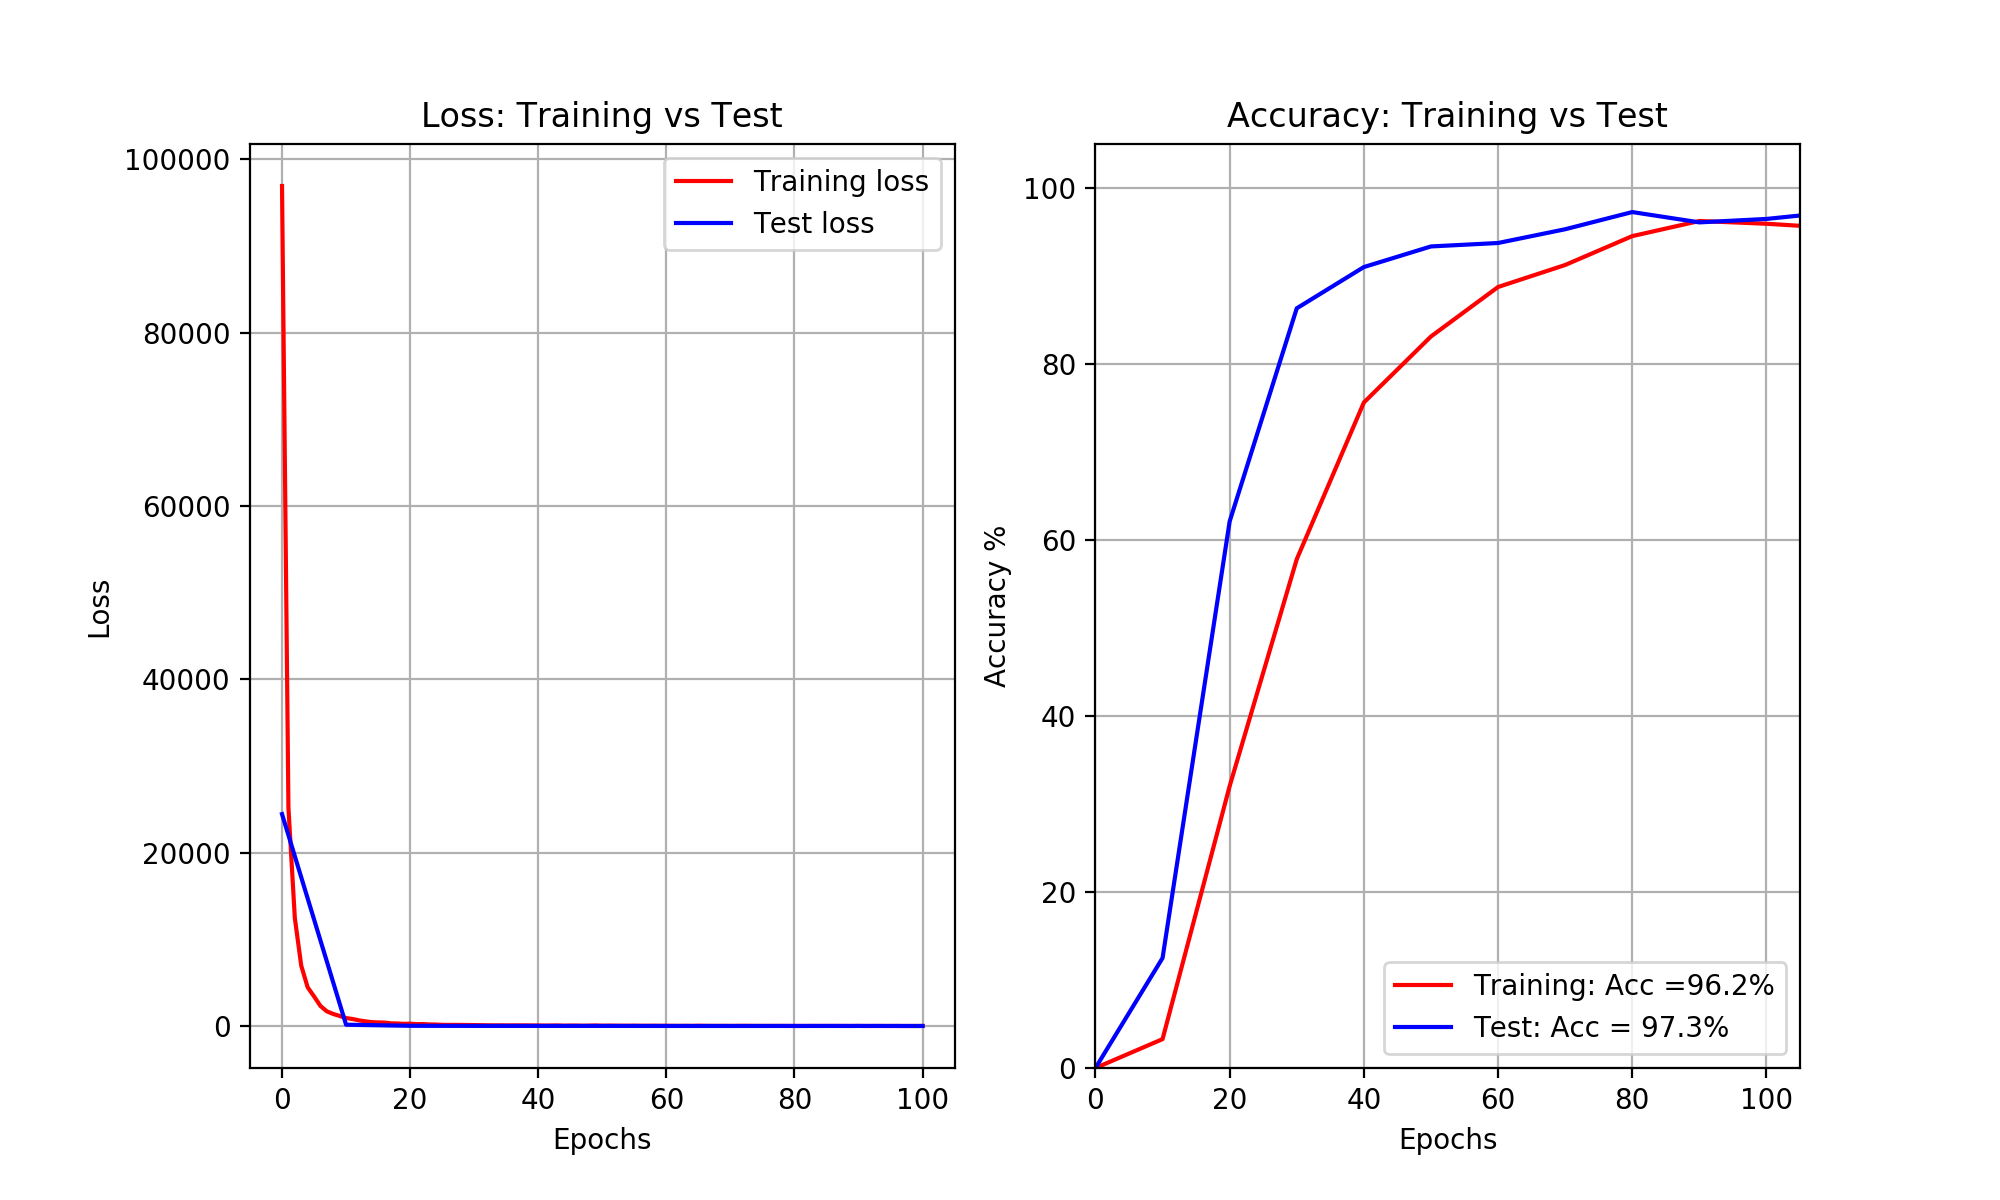

In [36]:
# Plots training loss
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 6))
ax1.plot(training_loss, color='red', label='Training loss')
ax1.plot(test_loss[0], test_loss[1],color ='blue',label='Test loss')
ax1.set_title('Loss: Training vs Test')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.margins(.05)
ax1.legend(loc='best')
ax1.grid()

# plot test accuracy
ax2.plot(np.array(range(len(training_accuracy))) * display_step_size, training_accuracy,
         color="red", label='Training: Acc ={0:.1f}%'.format(np.max(training_accuracy)))
ax2.plot(np.array(range(len(test_accurracy))) * display_step_size, test_accurracy,
         color="blue", label='Test: Acc = {0:.1f}%'.format(np.max(test_accurracy)))
ax2.set_title('Accuracy: Training vs Test')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy %')
ax2.axis([0, max_epochs + 5, 0, 105])
ax2.legend(loc='best')
ax2.grid()

#show the plots
plt.show()

# Prediction
Let's use our trained network to predict which drug a picture belongs to.

We will randomly load a picture and then show the prediction. You can try several examples by re-running.

In [35]:
#location of the weights/biases and architecture for the CNN (saved above)
model_for_identification = model_checkpoint

#called to identify subject in image
def identify(image):
    #reshape the image to an (1, 154587) vector
    image = np.mat(np.asarray(image).flatten())
    #create session
    with tf.Session() as sess:
        #load in the saved weights
        saver.restore(sess, model_for_identification)
        #find the prediction
        result = sess.run(pred, feed_dict={X: image, keep_prob: 1.})
        #we can look at the softmax output as well
        prob_array = sess.run(output, feed_dict={X: image, keep_prob: 1.})
        #print("op",prob_array)
        
        #return result (add 1 as indexed from 1 not 0)
        return result[0], prob_array


#pick an image, subject 1 to 39 and image 1 to 10, let's throw randoms to choose
test_drug = random.randint(1,classes)
test_image = random.randint(1,100)

#location of image.
image_name = '1.37.png'

#Load png file using the PIL library
im = PIL.Image.open(join('images', str(test_drug) + '.' + str(test_image) + '.png'))

#catagorize
predicted_drug, predicted_prob = identify(im)

#load drug names
f = open('drug_names.txt')
firstline = f.readline()
drugs = firstline.split(',')
#print(predicted_drug,drugs[predicted_drug], test_drug, test_image)

#and print
if predicted_drug == test_drug:
    print("Drug",drugs[test_drug], "image", test_image, "\033[1mCORRECTLY\033[0m identified as drug", drugs[predicted_drug])
else:
    print("Drug",drugs[test_drug], "image", test_image, "\033[1mINCORRECTLY\033[0m identified as drug", drugs[predicted_drug])  


INFO:tensorflow:Restoring parameters from tmp/caffenet_pad_1.ckpt
Drug Acetaminophen image 86 CORRECTLY identified as drug Acetaminophen


<IPython.core.display.Javascript object>


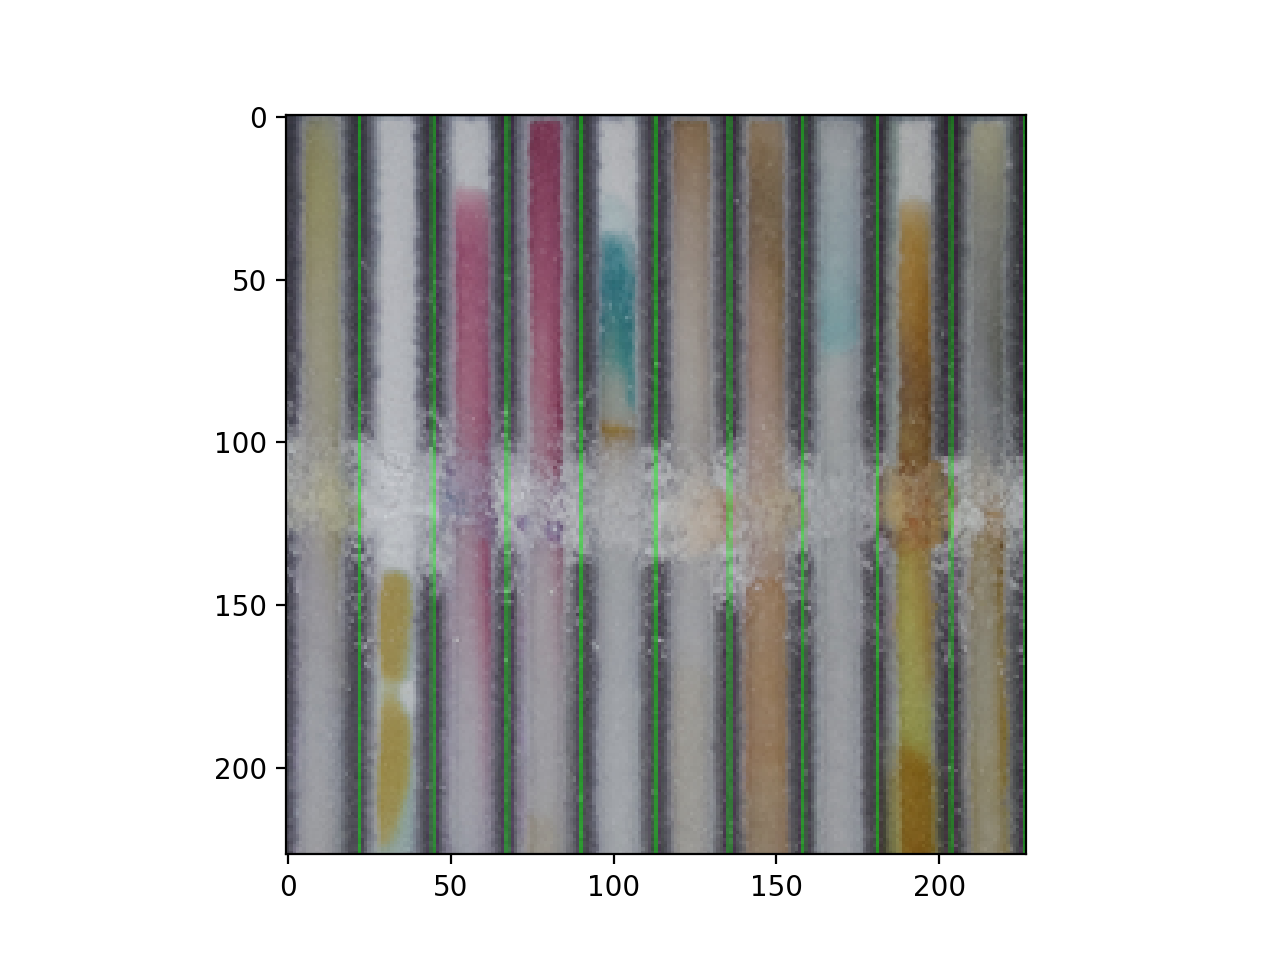

INFO:tensorflow:Restoring parameters from tmp/caffenet_pad_1.ckpt
Drug predicted to be Acetaminophen


In [57]:
#get it
urllib.request.urlretrieve( 'https://pad.crc.nd.edu/images/padimages/processed//Acetaminophen-12LanePADKenya2015-1-58861.processed.png', 'test.jpg')
#Load png file using the PIL library
img = PIL.Image.open('test.jpg')
#crop out active area
img = img.crop((71, 359, 71+636, 359+490))
#lanes split
lane = []

#exclude these lanes
exclude = "AJ"

#loop over lanes
for i in range(0,12):
    if chr(65+i) not in exclude:
        lane.append(img.crop((53*i, 0, 53*(i+1), 490)))

#reconstruct
imgout = Image.new("RGB", (53 * len(lane),490))

#loop over lanes
for i in range(0,len(lane)):
    imgout.paste(lane[i], (53*i, 0, 53*(i+1), 490))

#resize
imgout = imgout.resize((227,227), Image.ANTIALIAS)

#show it
imgplot = plt.imshow(imgout)

#catagorize
predicted_drug, predicted_prob = identify(imgout)

print("Drug predicted to be", drugs[predicted_drug])
